# 1. Import library

In [1]:
import numpy as np
import pandas as pd
import requests
import json
import datetime as dt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense,LSTM,Dropout,Flatten
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras import Sequential

# 2. Download data from binance

In [4]:
def get_data(symbol, interval, startTime, endTime):
    
    url = 'https://api.binance.com/api/v3/klines'
    startTime = str(int(startTime.timestamp() * 1000)) #получаем метку времени
    endTime = str(int(endTime.timestamp() * 1000))
    limit = '1000'
    meaning = {'symbol' : symbol, 'interval' : interval, 'startTime' : startTime, 'endTime' : endTime, 'limit' : limit} #создаем словарь
    response = requests.get(url, params = meaning) #отправляем запрос на получение данных
    if response.status_code == 200:
        data = response.json() #форматируем в json
        df = pd.DataFrame(data).iloc[:,0:6]
        df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']
        df["open"] = pd.to_numeric(df["open"])
        df["high"] = pd.to_numeric(df["high"])
        df["low"] = pd.to_numeric(df["low"])
        df["close"] = pd.to_numeric(df["close"])
        df["volume"] = pd.to_numeric(df["volume"])
        
    else:
        print(f'Error: Could not data with {symbol}')
    return df


In [5]:
months = [dt.datetime(2022,i,1) for i in range(1,13)]
months.append(dt.datetime(2023,1,1))
months.append(dt.datetime(2023,2,1))
months.append(dt.datetime(2023,3,1))
months.append(dt.datetime(2023,4,1))
months.append(dt.datetime(2023,5,1))
months.append(dt.datetime(2023,6,1))
months

[datetime.datetime(2022, 1, 1, 0, 0),
 datetime.datetime(2022, 2, 1, 0, 0),
 datetime.datetime(2022, 3, 1, 0, 0),
 datetime.datetime(2022, 4, 1, 0, 0),
 datetime.datetime(2022, 5, 1, 0, 0),
 datetime.datetime(2022, 6, 1, 0, 0),
 datetime.datetime(2022, 7, 1, 0, 0),
 datetime.datetime(2022, 8, 1, 0, 0),
 datetime.datetime(2022, 9, 1, 0, 0),
 datetime.datetime(2022, 10, 1, 0, 0),
 datetime.datetime(2022, 11, 1, 0, 0),
 datetime.datetime(2022, 12, 1, 0, 0),
 datetime.datetime(2023, 1, 1, 0, 0),
 datetime.datetime(2023, 2, 1, 0, 0),
 datetime.datetime(2023, 3, 1, 0, 0),
 datetime.datetime(2023, 4, 1, 0, 0),
 datetime.datetime(2023, 5, 1, 0, 0),
 datetime.datetime(2023, 6, 1, 0, 0)]

In [6]:
data_list = [get_data('BTCUSDT', '1h',months[i], months[i+1] - dt.timedelta(0,1)) for i in range(0, len(months) - 1)]

In [7]:
df = pd.concat(data_list,ignore_index=True)
df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
df.to_csv("BTCUSDT.csv")
df

datetime      open      high       low     close      volume
0     2021-12-31 20:00:00  45728.28  46211.07  45678.00  45879.24  1831.41202
1     2021-12-31 21:00:00  45886.66  46513.67  45766.85  46333.86  1734.69585
2     2021-12-31 22:00:00  46333.87  46569.97  46232.36  46303.99   991.85142
3     2021-12-31 23:00:00  46303.98  46520.13  46132.04  46216.93   985.99762
4     2022-01-01 00:00:00  46216.93  46731.39  46208.37  46656.13  1503.33095
...                   ...       ...       ...       ...       ...         ...
11769 2023-05-06 06:00:00  29346.99  29388.56  29250.65  29386.17  1516.70255
11770 2023-05-06 07:00:00  29386.18  29437.01  29362.50  29363.35   963.10696
11771 2023-05-06 08:00:00  29363.34  29367.20  29132.14  29330.12  2790.29274
11772 2023-05-06 09:00:00  29330.12  29356.47  29280.00  29285.06   832.71111
11773 2023-05-06 10:00:00  29285.05  29327.71  29210.00  29246.36  1772.58072

[11774 rows x 6 columns]

# 3. Exploratory analysis

In [8]:
fig = go.Figure(data=[go.Candlestick(x=df['datetime'],
                     open = df['open'],
                     high = df['high'],
                     low = df['low'],
                     close = df['close'])])
fig.update_layout(title_text="Bitcoin stock")
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Price")
fig.show()

In [9]:
df.isna().sum() #проверим на пропуски

datetime    0
open        0
high        0
low         0
close       0
volume      0
dtype: int64

In [10]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11774 entries, 0 to 11773
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  11774 non-null  datetime64[ns]
 1   open      11774 non-null  float64       
 2   high      11774 non-null  float64       
 3   low       11774 non-null  float64       
 4   close     11774 non-null  float64       
 5   volume    11774 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 552.0 KB


In [11]:
df.describe()

open          high           low         close         volume
count  11774.000000  11774.000000  11774.000000  11774.000000   11774.000000
mean   27279.171751  27399.556425  27155.877747  27277.773677    6923.578803
std     9153.561772   9199.537603   9105.382766   9152.000754    7317.498562
min    15648.230000  15769.990000  15476.000000  15649.520000       0.000000
25%    20009.452500  20099.872500  19917.335000  20009.407500    1828.969818
50%    23423.700000  23509.810000  23347.740000  23423.415000    4925.307455
75%    36000.812500  36167.960000  35833.912500  35998.412500    9297.606010
max    47970.980000  48189.840000  47811.400000  47970.990000  137207.188600

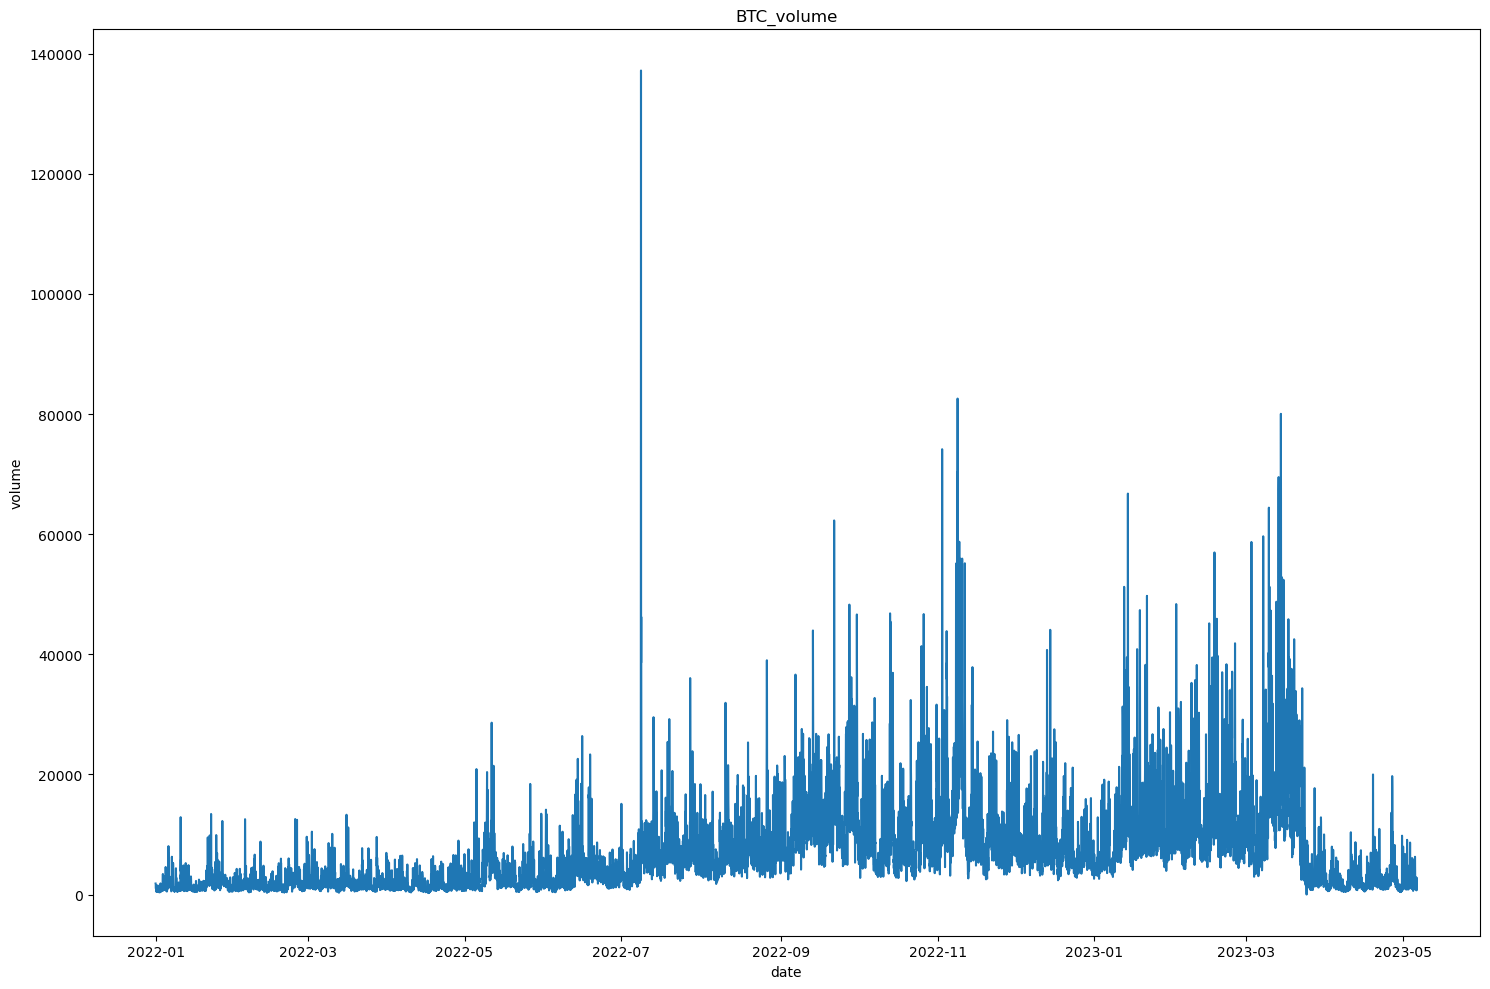

In [12]:
# Now let's plot the total volume of stock being traded each day
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(df['datetime'], df['volume'], color='tab:blue')
plt.ylabel('volume')
plt.xlabel('date')
plt.title("BTC_volume")
    
plt.tight_layout()

In [13]:
df.corr(numeric_only=1)

open      high       low     close    volume
open    1.000000  0.999865  0.999860  0.999788 -0.470644
high    0.999865  1.000000  0.999759  0.999880 -0.466592
low     0.999860  0.999759  1.000000  0.999887 -0.475085
close   0.999788  0.999880  0.999887  1.000000 -0.470602
volume -0.470644 -0.466592 -0.475085 -0.470602  1.000000

In [14]:
df['delta'] = df['close'].pct_change()

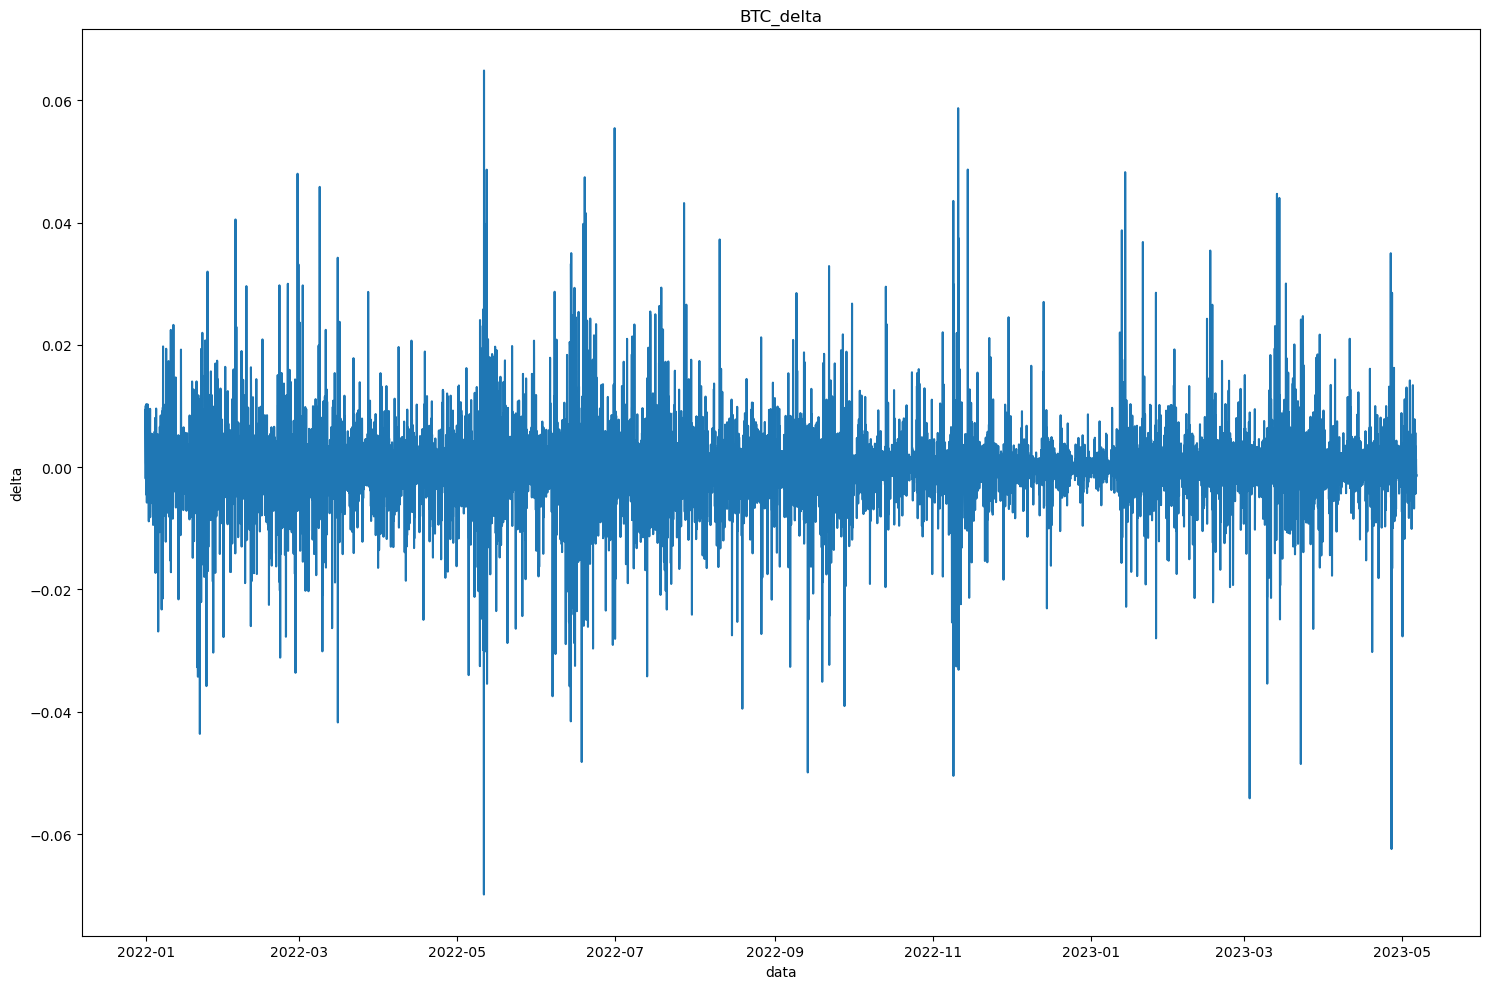

In [15]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(df['datetime'], df['delta'], color='tab:blue')
plt.ylabel('delta')
plt.xlabel('data')
plt.title("BTC_delta")
    
plt.tight_layout()

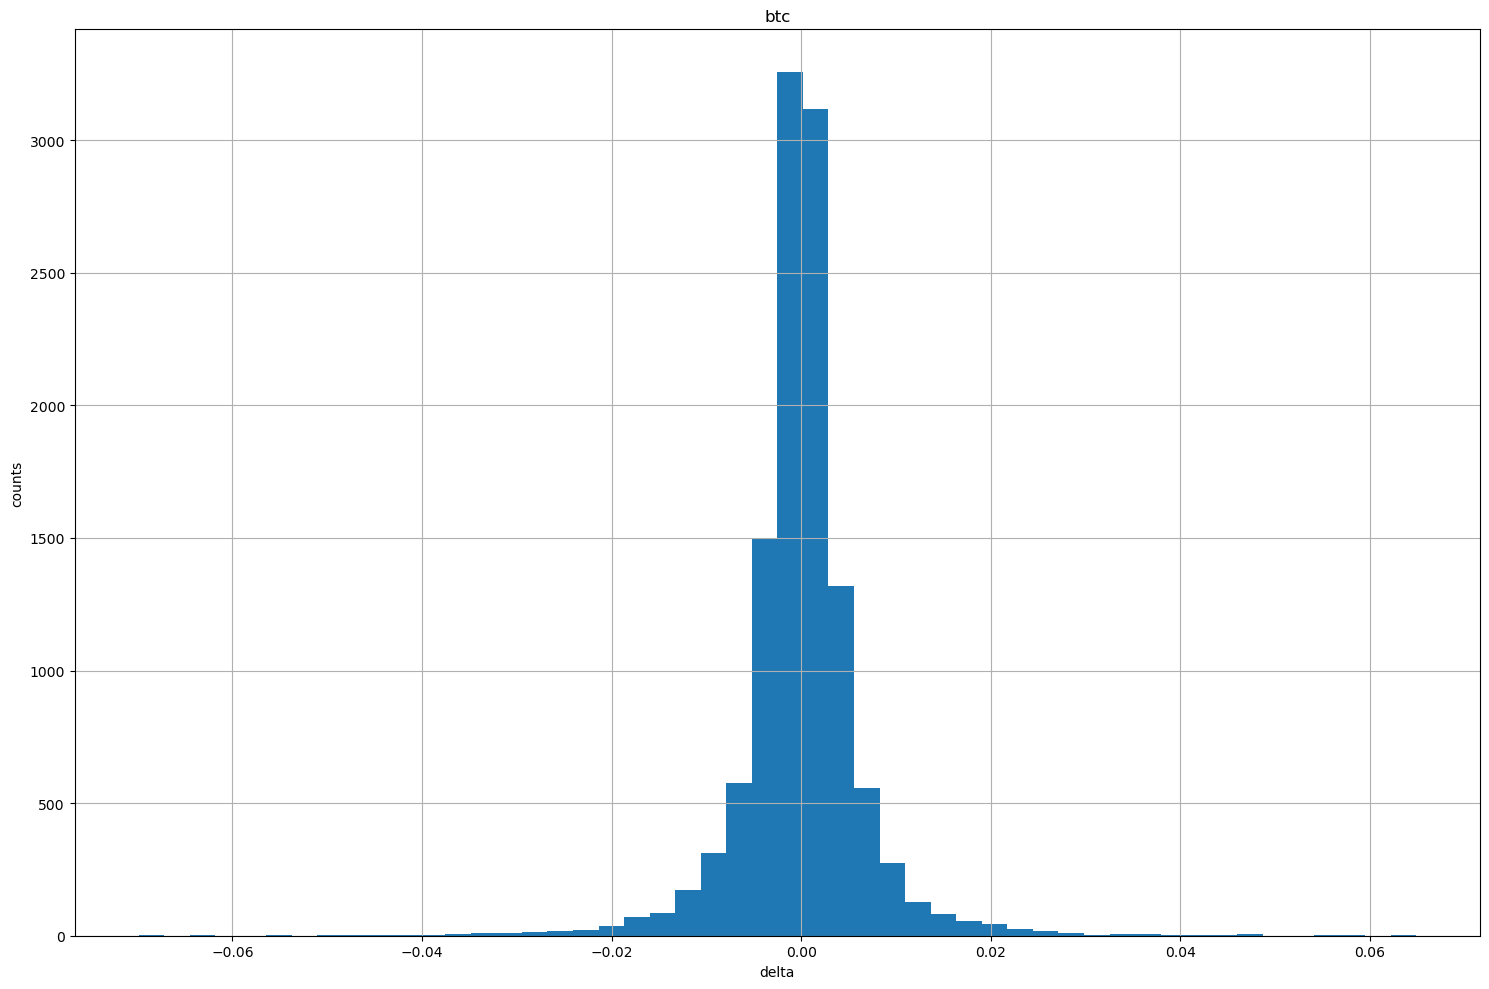

In [16]:
plt.figure(figsize=(15, 10))
df['delta'].hist(bins=50)
plt.xlabel('delta')
plt.ylabel('counts')
plt.title('btc')
    
plt.tight_layout()

Выводы разведовательного анализа данных:
* Цены закрытия/открытия/самая высокая/самая низкая имеют высокую корреляцию между собой,0,99. Поэтому имеет смысл выбрать один из этих показателей для анализа. Преимущественно для анализа выбирают показатель - цена закрытия.
* Корреляция между ценой и объемом - 0,47.Принято считать такую связь слабой, однако обратная связь имеется и при построении модели с двумя входами можно будет попробовать учесть этот показатель
* СКО имеет достаточно большое значение относительно средней цены акции, можно сказать, что актив является волатильным на исследуемом промежутке времени
* распределение отклонений разности цены закрытия за текущий и предыдущий день в % является нормальным, в основном цена на актив не отклоняется более чем на 0,02 % в день

# 4. Model

In [17]:
train_data, test_data = np.split(df, [int(.8*len(df))])

In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9419 entries, 0 to 9418
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  9419 non-null   datetime64[ns]
 1   open      9419 non-null   float64       
 2   high      9419 non-null   float64       
 3   low       9419 non-null   float64       
 4   close     9419 non-null   float64       
 5   volume    9419 non-null   float64       
 6   delta     9418 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 515.2 KB


In [19]:
train = train_data['close'].values #Return a Numpy representation of the DataFrame.
test = test_data['close'].values

In [20]:
test = np.reshape(test, (len(test), 1))

In [21]:
train = np.reshape(train, (len(train), 1)) #преобразуем массив в массив с кол-вом элементов равному длине выборки
scaler = StandardScaler() #Z-normilize z = (x - u) / s
training_values = scaler.fit_transform(train)

In [22]:
train_data = training_values[0:len(train), :]
X_train = []
y_train = []
num = 60
for i in range(num, len(training_values)):
    X_train_ = np.reshape(training_values[i-num:i, 0], (num, 1))
    X_train.append(X_train_)
    y_train.append(training_values[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)

In [23]:
batch_size=32

In [24]:
# creates model
model1 = Sequential()
model1.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model1.add(Dropout(0.02))
model1.add(LSTM(50,return_sequences=True))
model1.add(Dropout(0.02))
model1.add(LSTM(50,return_sequences=True))
model1.add(Dropout(0.02))
model1.add(LSTM(50,return_sequences=False))
model1.add(Dropout(0.02))
model1.add(Dense(1))

#compile the model
model1.compile(optimizer='adam',loss='mse')

# Train the model
model1.fit(X_train,y_train,epochs=20,batch_size=batch_size, verbose=2, shuffle=True, steps_per_epoch=int(X_train.shape[0]/batch_size))

Epoch 1/20
292/292 - 44s - loss: 0.0218 - 44s/epoch - 149ms/step
Epoch 2/20
292/292 - 35s - loss: 0.0049 - 35s/epoch - 121ms/step
Epoch 3/20
292/292 - 35s - loss: 0.0040 - 35s/epoch - 121ms/step
Epoch 4/20
292/292 - 36s - loss: 0.0039 - 36s/epoch - 122ms/step
Epoch 5/20
292/292 - 36s - loss: 0.0032 - 36s/epoch - 122ms/step
Epoch 6/20
292/292 - 36s - loss: 0.0029 - 36s/epoch - 122ms/step
Epoch 7/20
292/292 - 36s - loss: 0.0029 - 36s/epoch - 122ms/step
Epoch 8/20
292/292 - 36s - loss: 0.0025 - 36s/epoch - 122ms/step
Epoch 9/20
292/292 - 35s - loss: 0.0024 - 35s/epoch - 121ms/step
Epoch 10/20
292/292 - 36s - loss: 0.0022 - 36s/epoch - 123ms/step
Epoch 11/20
292/292 - 36s - loss: 0.0021 - 36s/epoch - 122ms/step
Epoch 12/20
292/292 - 36s - loss: 0.0022 - 36s/epoch - 122ms/step
Epoch 13/20
292/292 - 36s - loss: 0.0018 - 36s/epoch - 123ms/step
Epoch 14/20
292/292 - 36s - loss: 0.0019 - 36s/epoch - 123ms/step
Epoch 15/20
292/292 - 36s - loss: 0.0018 - 36s/epoch - 122ms/step
Epoch 16/20
292/292

In [25]:
df_volume = np.vstack((train, test)) #соединим данные

inputs = df_volume[df_volume.shape[0] - test.shape[0] - num:] #тестовая без 60
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

num_2 = df_volume.shape[0] - len(train) + num #тестовая плюс 60 

X_test = []

for i in range(num, num_2):
    X_test_ = np.reshape(inputs[i-num:i, 0], (num, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [26]:
predict = model1.predict(X_test)
predict = scaler.inverse_transform(predict)

74/74 [==============================] - 4s 37ms/step


In [27]:
def get_metrics(test,
                predict,      
                name: str = None):
    "таблица с метриками"
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    df_metrics['MSE'] = mean_squared_error(test, predict)
    df_metrics['MAE'] = mean_absolute_error(test, predict)
    df_metrics['RMSE'] = np.sqrt(mean_squared_error(test, predict))
    df_metrics['MAPE_%'] = mean_absolute_percentage_error(test, predict)

    return df_metrics

In [28]:
metrics = get_metrics(test, predict, 'Model1')
metrics

model           MSE         MAE        RMSE    MAPE_%
0  Model1  52072.525072  169.053798  228.194051  0.006868

In [43]:
model2 = Sequential()
model2.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model2.add(Dropout(0.02))
model2.add(LSTM(100, return_sequences=False))
model2.add(Dense(25))
model2.add(Dense(1))

#compile the model
model2.compile(optimizer='adam',loss='mse', metrics='mean_absolute_error')

# Train the model
model2.fit(X_train,y_train,epochs=20,batch_size=batch_size, shuffle=True, steps_per_epoch=int(X_train.shape[0]/batch_size))

Epoch 1/20
292/292 [==============================] - 22s 63ms/step - loss: 0.0111 - mean_absolute_error: 0.0498
Epoch 2/20
292/292 [==============================] - 19s 64ms/step - loss: 0.0017 - mean_absolute_error: 0.0274
Epoch 3/20
292/292 [==============================] - 19s 65ms/step - loss: 0.0016 - mean_absolute_error: 0.0276
Epoch 4/20
292/292 [==============================] - 19s 65ms/step - loss: 0.0013 - mean_absolute_error: 0.0251
Epoch 5/20
292/292 [==============================] - 19s 65ms/step - loss: 0.0012 - mean_absolute_error: 0.0236
Epoch 6/20
292/292 [==============================] - 19s 65ms/step - loss: 0.0011 - mean_absolute_error: 0.0236
Epoch 7/20
292/292 [==============================] - 19s 64ms/step - loss: 9.5653e-04 - mean_absolute_error: 0.0215
Epoch 8/20
292/292 [==============================] - 19s 64ms/step - loss: 9.9414e-04 - mean_absolute_error: 0.0223
Epoch 9/20
292/292 [==============================] - 19s 64ms/step - loss: 9.0006e-04 -

In [47]:
predict = model2.predict(X_test)
predict = scaler.inverse_transform(predict)

74/74 [==============================] - 2s 22ms/step


In [48]:
metrics = pd.concat([metrics, get_metrics(test, predict, 'Model2')], ignore_index=True)
metrics

model           MSE         MAE        RMSE    MAPE_%
0  Model1  52072.525072  169.053798  228.194051  0.006868
1  Model2  22767.966907   89.525868  150.890579  0.003475

In [35]:
model3 = Sequential()
model3.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model3.add(Dropout(0.02))
model3.add(LSTM(128, return_sequences=True))
model3.add(LSTM(128, return_sequences=False))
model3.add(Dense(32))
model3.add(Dense(1))

#compile the model
model3.compile(optimizer='adam',loss='mse', metrics='mean_absolute_error')

# Train the model
model3.fit(X_train,y_train,epochs=20,batch_size=batch_size, shuffle=True, steps_per_epoch=int(X_train.shape[0]/batch_size))

Epoch 1/20
292/292 [==============================] - 40s 118ms/step - loss: 0.0147 - mean_absolute_error: 0.0590
Epoch 2/20
292/292 [==============================] - 35s 119ms/step - loss: 0.0024 - mean_absolute_error: 0.0340
Epoch 3/20
292/292 [==============================] - 35s 119ms/step - loss: 0.0022 - mean_absolute_error: 0.0334
Epoch 4/20
292/292 [==============================] - 35s 121ms/step - loss: 0.0018 - mean_absolute_error: 0.0297
Epoch 5/20
292/292 [==============================] - 35s 119ms/step - loss: 0.0016 - mean_absolute_error: 0.0281
Epoch 6/20
292/292 [==============================] - 35s 119ms/step - loss: 0.0014 - mean_absolute_error: 0.0261
Epoch 7/20
292/292 [==============================] - 35s 119ms/step - loss: 0.0012 - mean_absolute_error: 0.0245
Epoch 8/20
292/292 [==============================] - 35s 119ms/step - loss: 0.0013 - mean_absolute_error: 0.0256
Epoch 9/20
292/292 [==============================] - 35s 119ms/step - loss: 8.9468e-04 

In [71]:
predict = model3.predict(X_test)
predict = scaler.inverse_transform(predict)

74/74 [==============================] - 3s 43ms/step


In [50]:
metrics = pd.concat([metrics, get_metrics(test, predict, 'Model3')], ignore_index=True)
metrics

model           MSE         MAE        RMSE    MAPE_%
0  Model1  52072.525072  169.053798  228.194051  0.006868
1  Model2  22767.966907   89.525868  150.890579  0.003475
2  Model3  23239.175822   96.556674  152.444009  0.003809

In [45]:
#metrics = metrics.drop(labels = [1,2,3],axis = 0)

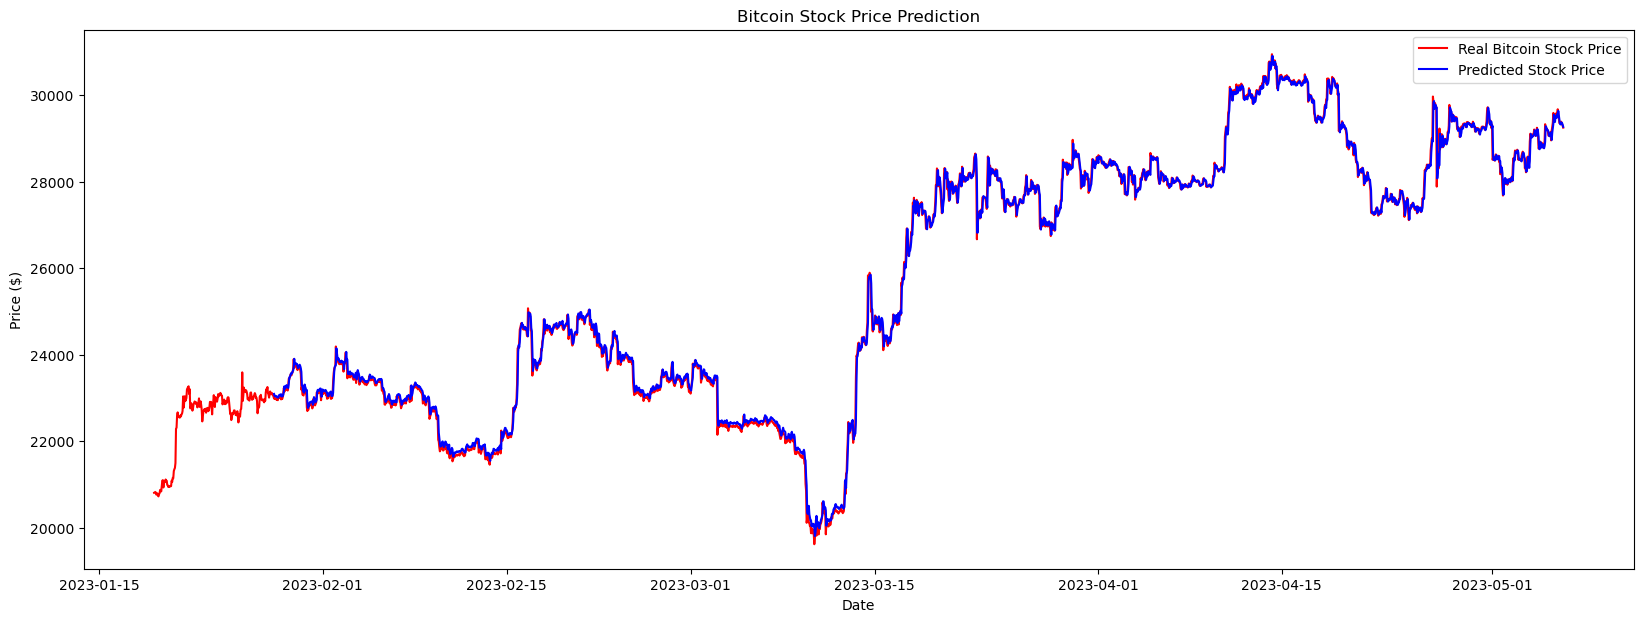

In [84]:
plt.figure(figsize=(20,7))
plt.plot(df['datetime'][9200:], df_volume[9200:], color = 'red', label = 'Real Bitcoin Stock Price')
plt.plot(df['datetime'][-predict.shape[0]:], predict, color = 'blue', label = 'Predicted Stock Price')
plt.title('Bitcoin Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [52]:
df_volume = np.vstack((train, test)) #соединим данные

inputs = df_volume[df_volume.shape[0] - test.shape[0] - num:] #тестовая без 30 -2300
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

num_2 = df_volume.shape[0] - len(train) + num #тестовая плюс 30 2330

X_test = []

for i in range(num, num_2):
    X_test_ = np.reshape(inputs[i-num:i, 0], (num, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [63]:
pred_ = predict[-1].copy()
prediction_full = []
window = 60
df_copy = df.iloc[:, 4:5][1:].values

for j in range(1):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:len(train)]
    test_ = df_[len(train):]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = scaler.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)

    predict_ = model3.predict(X_test_)
    pred_ = scaler.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[1:]

74/74 [==============================] - 3s 44ms/step


In [64]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

In [78]:
predict_price_for_next_hour=float(prediction_full_new[-1:])
predict_price_for_next_hour

29226.744140625

In [73]:
df_date = df[['datetime']]

for h in range(1):
    df_date_add = pd.to_datetime(df_date['datetime'].iloc[-1]) + pd.DateOffset(hours=1)
    df_date_add = pd.DataFrame([df_date_add.strftime("%m/%d/%Y, %H:%M:%S")], columns=['datetime'])
    df_date = pd.concat([df_date,df_date_add])
df_date = df_date.reset_index(drop=True)

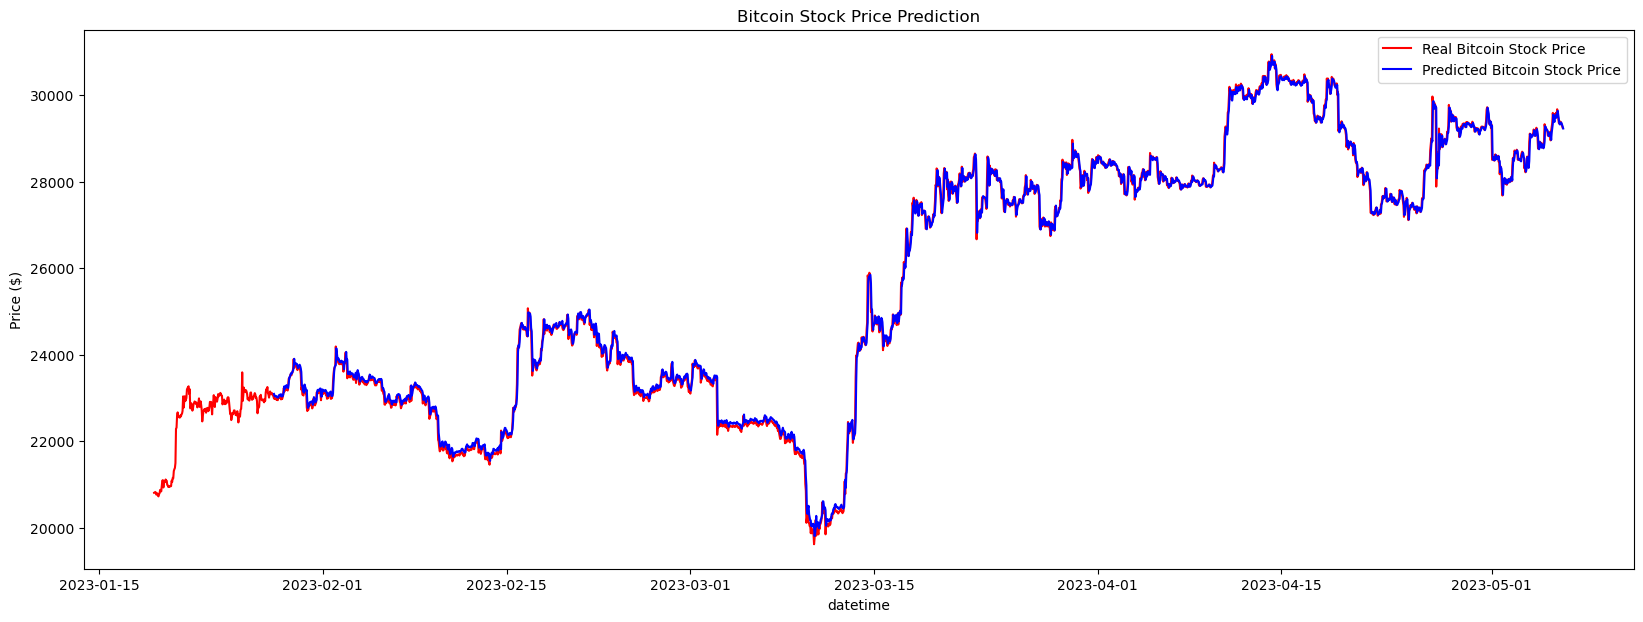

In [83]:
plt.figure(figsize=(20,7))
plt.plot(df['datetime'][9200:], df_volume[9200:], color = 'red', label = 'Real Bitcoin Stock Price')
plt.plot(pd.to_datetime(df_date['datetime'][-prediction_full_new.shape[0]:]), prediction_full_new, color = 'blue', label = 'Predicted Bitcoin Stock Price')
plt.title('Bitcoin Stock Price Prediction')
plt.xlabel('datetime')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

Выводы:
* Присутсвует большая разница между оценками качетва (MSE, MAE, RMSE, MAPE) прогнозными значениями на тестововой выборке и на тренировочной.Это значит, что имеется большой разброс. Методы борьбы с разбросом:
При наличии больших вычислительных мощностей, можно попробовать добавить данные в модель.
Упростить архитектору модели. Архитектура упрощена, но результаты не стали приемлемые.
Добавить слой Dropout. Добавлен во всех моделях, практиковался с различными значениям, но не дает оптимальных результатов.
Добавить признаки в модель. Например объем транзакций.
* Predict на следующий час отрабатвает нормально, но предикт начиная с 3го часа не справляется совсем со своей задачей. Возможно нужно попробовать предсказать дельту - разницу между ценой закрытия предыдущего и текущего дня.
* Признак объем транзакция имеет небольшую корреляцию, может не дать ожидаемых результатов. Вместо или вместе с этим, можно попробовать подать в модель новостные данные (твиттер, фейсбук и тд).